# 0. SET UP

In [1]:
import os
os.chdir('D:/jobs/Google Kickstarter')

import warnings
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import random
from CHAID import Tree

import sklearn.metrics as sk_metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_array
from sklearn import tree as sk_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import learn

from scipy import stats

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import graphviz
#import google.datalab.bigquery as bq
#import google.datalab

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
db = pd.read_csv('ML_PL_short.csv',sep=';',decimal=',', parse_dates=True,
                dtype={'DaysAdvance': float, 'Price_Ticket_per_pax': float, 'distance':float,
                       'Airline': str, 'BrowserName': str, 'DepartureCode': str,
                      'DestinationCode': str, 'TripType': str, 'AvailablePaymentTypes': str, 'EventSource': str})

In [3]:
print(list(db))

['UTCDate', 'UTCTimeStamp', 'Session', 'User', 'ClientIp', 'Airline', 'AvailablePaymentTypes', 'BrowserColors', 'BrowserIncognitoMode', 'BrowserName', 'BrowserScreen', 'BrowserScreen_W', 'BrowserScreen_H', 'BrowserVersion', 'CheckInDate', 'CheckOutDate', 'DepartureCode', 'DestinationCode', 'EventSource', 'FlightChangeTime', 'FlightTime', 'Installments', 'MobileDevice', 'Partner', 'PaxConfiguration', 'Provider', 'Rule', 'StepInsurance', 'System', 'TripType', 'WithAncillaryAirHelp', 'WithAncillaryBaggageTracking', 'WithAncillaryCheckIn', 'WithAncillaryServicePack', 'WithAncillarySms', 'WithInsurance', 'WithLuggage', 'AncillaryAirHelpPrice', 'AncillaryBaggageTrackingPrice', 'AncillaryCheckInPrice', 'AncillaryServicePackPrice', 'AncillarySmsPrice', 'Price', 'Price2', 'PriceIns', 'PriceTF', 'DaysAdvance', 'PricingDayOfWeek', 'PricingHour', 'CheckInDayOfWeek', 'CheckInHour', 'Flight_Time', 'FlightChange_Time', 'Booking', 'BookingWithInsurance', 'Pax_adults', 'Pax_youngs', 'Pax_kids', 'Pax_in

Add Price and Price2

In [4]:
db['Price'] = db['Price'] + db['Price2']

# 1. Data preparations

In [5]:
print("Training features summary:")
print(db.describe())

Training features summary:
       BrowserColors  BrowserIncognitoMode  BrowserScreen_W  BrowserScreen_H  \
count  339973.000000         339973.000000    339973.000000    339973.000000   
mean       25.807885              0.074421      1047.708206       786.485821   
std         3.367547              0.335556       559.651975       159.177993   
min         0.000000              0.000000         0.000000         0.000000   
25%        24.000000              0.000000       360.000000       640.000000   
50%        24.000000              0.000000      1280.000000       768.000000   
75%        24.000000              0.000000      1366.000000       864.000000   
max        32.000000              2.000000      5760.000000      2960.000000   

       BrowserVersion  Installments   MobileDevice       Provider  \
count   339973.000000      339973.0  339973.000000  339973.000000   
mean        60.287993           0.0       0.405206      17.419642   
std         93.152747           0.0       0.4

Drop Nan's

In [6]:
db = db.dropna()
print(db.shape)

(336333, 59)


Remove outliers for chosen numeric variables

In [7]:
num_with_poss_outliers = db[['Price', 'PriceIns', 'PriceTF', 'DaysAdvance', #continuous
                             'Pax_adults', 'Pax_youngs', 'Pax_kids', 'Pax_infants']] #integer

db = db[(np.abs(stats.zscore(num_with_poss_outliers)) < 3).all(axis=1)]

In [8]:
print(db.shape)

(295075, 59)


# 1.1. Explanatory analysis

CHAID for categorical variables https://github.com/Rambatino/CHAID

In [ ]:
print(list(db.select_dtypes(include=['object'])))

In [ ]:
## set the CHAID input parameters
independent_variable_columns = [list(db.select_dtypes(include=['object']))[i] 
                                for i in [5,6,7,8,11,12,13,16,18,19,20,21]]
dep_variable = 'BookingWithInsurance'

In [ ]:
## create the Tree via pandas
tree = Tree.from_pandas_df(
    db[independent_variable_columns+[dep_variable]],
    dict(zip(independent_variable_columns, ['nominal'] * len(independent_variable_columns))),
    dep_variable)

In [ ]:
print(dir(tree))

In [ ]:
tree.print_tree()

Analyze Decision Tree to find the best features

In [ ]:
clf_gini = sk_tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=7, min_samples_leaf=100, class_weight={0: 1, 1: 10})

In [ ]:
print(list(db.select_dtypes(include=['float64','int64']).drop(['Booking','BookingWithInsurance'], 1)))

In [ ]:
clf_gini = clf_gini.fit(
    db.select_dtypes(include=['float64','int64']).drop(['Booking','BookingWithInsurance'], 1), db[['Booking']])

In [ ]:
print(dir(clf_gini))

Take a look on feature importance

In [ ]:
print({list(db.select_dtypes(include=['float64','int64']).drop(['Booking','BookingWithInsurance'], 1))[i] : 
       clf_gini.feature_importances_[i] 
       for i in range(len(clf_gini.feature_importances_))})

In [ ]:
#export to 
#sk_tree.export_graphviz(clf_gini,out_file='tree.dot')  

In [ ]:
#I tried to visualize it with graphviz, but I doesn't work

# 1.2 Data preparations

Define features and target sets. Features are prepared based on CHAID and DecisionTreeClassifier

Define categorical and continuous variables

In [9]:
categorical_vars_few = ['BrowserName','AvailablePaymentTypes','MobileDevice','WithLuggage',
                        'PricingDayOfWeek','PricingHour','CheckInDayOfWeek','CheckInHour']
categorical_vars_many = ['DepartureCode','DestinationCode','BrowserScreen','System','Airline']
continues_vars = ['Price','PriceIns','PriceTF','DaysAdvance',
                  'Pax_adults', 'Pax_youngs', 'Pax_kids', 'Pax_infants']

In [10]:
X_db = db[categorical_vars_few + categorical_vars_many + continues_vars]
y_db = db[['BookingWithInsurance']]

Remove nan's from X_db & y_db (based on nan's in X_db)

In [11]:
print(X_db.shape)
print(y_db.shape)

X_db = X_db.dropna()
y_db = y_db.loc[X_db.index]

print(X_db.shape)
print(y_db.shape)

(295075, 21)
(295075, 1)
(295075, 21)
(295075, 1)


Rescale continues variable - for binary classifier it is prefer to used rescaler with the same range as activation function
https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1), copy=False)
scaler.fit(X_db[continues_vars])
#scaler = StandardScaler(copy=False).fit(X_db.loc[:,continues_vars]) - for standarization (worse)

X_db.loc[:,continues_vars] = scaler.transform(X_db.loc[:,continues_vars])

Prepare training and testing sets (shuffle and divide)

In [13]:
#X_db = X_db.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_db, y_db, test_size=0.2, random_state=123) #shuffling by default

In [14]:
print(X_test.dtypes)

BrowserName               object
AvailablePaymentTypes     object
MobileDevice               int64
WithLuggage                int64
PricingDayOfWeek           int64
PricingHour                int64
CheckInDayOfWeek           int64
CheckInHour                int64
DepartureCode             object
DestinationCode           object
BrowserScreen             object
System                    object
Airline                   object
Price                    float64
PriceIns                 float64
PriceTF                  float64
DaysAdvance              float64
Pax_adults               float64
Pax_youngs               float64
Pax_kids                 float64
Pax_infants              float64
dtype: object


Check the summaries of the variables

In [15]:
# Double-check that we've done the right thing.
print("Training features summary:")
print(X_train.describe())
print("Validation features summary:")
print(X_test.describe())

print("Training targets summary:")
print(y_train.describe())
print ("Validation targets summary:")
print(y_test.describe())

Training features summary:
        MobileDevice    WithLuggage  PricingDayOfWeek    PricingHour  \
count  236060.000000  236060.000000     236060.000000  236060.000000   
mean        0.409332       0.889630          3.809646      14.530230   
std         0.491712       0.313351          2.003060       5.058359   
min         0.000000       0.000000          1.000000       0.000000   
25%         0.000000       1.000000          2.000000      11.000000   
50%         0.000000       1.000000          4.000000      15.000000   
75%         1.000000       1.000000          6.000000      19.000000   
max         1.000000       1.000000          7.000000      23.000000   

       CheckInDayOfWeek    CheckInHour          Price       PriceIns  \
count     236060.000000  236060.000000  236060.000000  236060.000000   
mean           4.228268      12.912586      -0.815998      -0.761129   
std            1.972350       5.031712       0.235082       0.248104   
min            1.000000       0.0000

# 2. Set hyperparameters and make final preparations

In [72]:
learning_rate=0.025 #Generally, a learning rate of 0.01 is a safe bet
steps=200000
batch_size=128 #Commonly, a batch of 16 to 128 examples is a good choice(exponential of 2).
hidden_units=[[128,16],32] #As @Yoshua-Bengio mentioned on Quora - “You just keep on adding layers, until the test error doesn’t improve anymore”
periods = 100
steps_per_period = steps / periods
#regularization parameter for L1 (beta1) and L2 (beta2)
beta=[0.001, 0.001]
dropout_p = 0.2 #None or scalar. A default value of 0.5 is a good choice
threshold = None #Acceptance threshold for rare events. Default is 0.5. Works for binary classifier, else set 'None' 

Add column with the weights

In [73]:
#calculate the value to have equal distribution 50%-50% for both binary classes
equal_point = len(np.where(y_train==1)[0])/len(np.where(y_train==0)[0]) #equality weigth between positives and negatives
print(equal_point)

incr_coef=1.0 #increase the significance of positives in comparison to negatives

X_train.loc[:,'weight'] = np.where(y_train==1,incr_coef*1/equal_point,1)
X_test.loc[:,'weight'] = np.where(y_test==1,incr_coef*1/equal_point,1)

X_train.loc[:,'weight'] = X_train.loc[:,'weight'].astype('float32')
X_test.loc[:,'weight'] = X_test.loc[:,'weight'].astype('float32')

0.028068723733205583


C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Define weights which will be used in loss calculation

In [74]:
#prepare numeric features with standarization
# normalizer could be used, but I used MinMaxScaler before
#normalizer_fn = lambda x: (x - tf.nn.moments(x,axes = 0)[0] / tf.nn.moments(x,axes = 0)[1])
num_features = [tf.feature_column.numeric_column(my_feature)
              for my_feature in X_train[continues_vars]]

#create embedding column from categorical with defined vacabulary list 
#(number of embedding columns is equal to unique())
cats_l_features = [tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key=my_feature,
        vocabulary_list=X_train[my_feature].unique()),
    len(X_train[my_feature].unique()))
                  for my_feature in X_train[categorical_vars_few]
                  ]

#create indicator column from hash bucket column 
cats_h_features = [tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_hash_bucket(
    key=my_feature, 
    hash_bucket_size=60))
                       for my_feature in X_train[categorical_vars_many]
                  ]

Prepare dictionary for mapping keys and features

In [75]:
feature_final = num_features + cats_l_features + cats_h_features

In [76]:
print(feature_final)

[_NumericColumn(key='Price', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='PriceIns', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='PriceTF', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='DaysAdvance', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Pax_adults', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Pax_youngs', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Pax_kids', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='Pax_infants', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='BrowserName', vocabulary_list=('Chrome', 'Opera', 'Internet Explorer', 'Safari', 'Firefox', 'Edge', 'Ma

# 4. Setup Neural Network

Define model function

In [81]:
def my_model_fn(
   features, # This is batch_features from input_fn
   labels,   # This is batch_labels from input_fn
   mode,     # An instance of tf.estimator.ModeKeys
   params):  # Additional configuration

    
    #1. DEFINE LAYERS
    # Use `input_layer` to apply the feature columns.
    layer1 = tf.feature_column.input_layer(features, params['num_columns'] + params['cats_l_columns'])
    layer2 = tf.feature_column.input_layer(features, params['cats_h_columns'])
    
    # Build the hidden layers, sized according to the 'hidden_units' param.
    initializer = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") #https://smist08.wordpress.com/tag/he-initialization/
   
    for units in params['hidden_units']:
        if units == params['hidden_units'][0] :
            regularizer = layers.l1_l2_regularizer(scale_l1=params['beta'][0], scale_l2=params['beta'][1])
            layer1 = tf.layers.Dense(units=units[0], activation=tf.nn.relu, #tanh is preffered http://rishy.github.io/ml/2017/01/05/how-to-train-your-dnn/
                                    kernel_initializer=initializer, kernel_regularizer=regularizer,
                                    bias_initializer = tf.zeros_initializer())(layer1)
            layer2 = tf.layers.Dense(units=units[1], activation=tf.nn.tanh, #tanh is preffered http://rishy.github.io/ml/2017/01/05/how-to-train-your-dnn/
                                    kernel_initializer=initializer, kernel_regularizer=regularizer,
                                    bias_initializer = tf.zeros_initializer())(layer2)
            #add dropout for first layer
            if params['dropout_prob'] != None:
                layer1 = tf.nn.dropout(layer1,params['dropout_prob'])
                layer2 = tf.nn.dropout(layer2,params['dropout_prob'])
        else:
            layer = tf.layers.Dense(units=units, activation=tf.nn.elu, #tanh is preffered http://rishy.github.io/ml/2017/01/05/how-to-train-your-dnn/
                                    kernel_initializer=initializer,
                                    bias_initializer = tf.zeros_initializer())(tf.concat([layer1,layer2],axis=1))

    # Output layer - compute logits (1 per class).
    logits = tf.layers.Dense(units=params['n_classes'], activation=None,
                             kernel_initializer=initializer,
                             bias_initializer = tf.zeros_initializer())(layer)
    probs = tf.nn.softmax(logits)
    
    #2. PREDICT MODE
    #threshold
    if params['threshold'] != None:
        predicted_classes = tf.to_int32(probs[:,1] > params['threshold'])
    else:
        predicted_classes = tf.argmax(probs, 1)
        
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes,
            'probabilities': probs,
            'logits': logits
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    #3. TRAIN MODE
    # Compute loss.
    # Original loss function
    unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    print(tf.shape(unweighted_loss))
    #Weighted
    loss_weighted = tf.multiply(unweighted_loss, features[params['weight']])
    
    # Loss function using L1L2 Regularization
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #final loss function
    loss = tf.reduce_sum(loss_weighted) + tf.reduce_sum(regularization_losses)
    
    #Define optimizer
    optimizer = tf.train.AdagradOptimizer(learning_rate=params['learning_rate'])
    
    #Define steps
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)


    #4. EVALUATE MODE
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes,
                                   weights=features[params['weight']],
                                   name='acc_op')
    precision = tf.metrics.precision(labels=labels, predictions=predicted_classes,
                                   weights=features[params['weight']],
                                   name='prec_op')
    recall = tf.metrics.recall(labels=labels, predictions=predicted_classes,
                                   weights=features[params['weight']],
                                   name='rec_op')
    roc_auc = tf.metrics.auc(labels=labels, predictions=predicted_classes,
                                   weights=features[params['weight']],
                                   curve='ROC',name='roc_auc_op')
    pr_auc = tf.metrics.auc(labels=labels, predictions=predicted_classes,
                                   weights=features[params['weight']],
                                   curve='PR',name='pr_auc')
    
    metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
               'roc_auc': roc_auc, 'pr_auc': pr_auc}
    
    tf.summary.merge_all()

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

Create a classifier object.

In [82]:
dnn_classifier = tf.estimator.Estimator(
    model_fn=my_model_fn,
    params={
        #features
        'num_columns': num_features, 
        'cats_l_columns': cats_l_features,
        'cats_h_columns': cats_h_features,
        # Hidden layers
        'hidden_units': hidden_units,
        # The model must choose between 2 classes.
        'n_classes': 2,
        # Learning rate.
        'learning_rate': learning_rate,
        # Weight column.
        'weight': 'weight',
        # Regularization parameter (beta).
        'beta': beta,
        #Dropout probability.
        'dropout_prob':dropout_p,
        #Threshold
        'threshold':threshold
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\t.bak\\AppData\\Local\\Temp\\tmpdk9wgs6_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027AB0DBE550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# 4. Train the model

In [83]:
# Train the model, but do so inside a loop so that we can periodically assess loss metrics.
print("Training model...")
print("RMSE (on training data):")
log_loss_train_f = []
log_loss_test_f = []
accu_score_train_f = []
accu_score_test_f = []
roc_auc_train_f = []
roc_auc_test_f = []
precision_train_f = []
precision_test_f = []
recall_train_f = []
recall_test_f = []
pr_auc_train_f = []
pr_auc_test_f = []

for period in range (0, periods):
    print("Step %i"%(period))
    # Train the model, starting from the prior state.
    dnn_classifier.train(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            num_epochs=None,
            shuffle=True
        ),
        steps=steps_per_period
    )  # Output a graph of loss metrics over periods.
    
    # Take a break and compute predictions.
    training_predictions = dnn_classifier.predict(input_fn=tf.estimator.inputs.pandas_input_fn(X_train, y_train,shuffle=False))
    training_predictions = np.array([item['class_ids'] for item in training_predictions])
    validation_predictions = dnn_classifier.predict(input_fn=tf.estimator.inputs.pandas_input_fn(X_test, y_test,shuffle=False))
    validation_predictions = np.array([item['class_ids'] for item in validation_predictions])
    
    # Take a break and compute metrics on train and test db's. 
    evals_train = dnn_classifier.evaluate(input_fn=tf.estimator.inputs.pandas_input_fn(X_train, y_train,shuffle=False))    
    evals_test = dnn_classifier.evaluate(input_fn=tf.estimator.inputs.pandas_input_fn(X_test, y_test,shuffle=False))  
    
    # Add the loss metrics from this period to our list.
    log_loss_train_f.append(evals_train['loss'])
    log_loss_test_f.append(evals_test['loss'])
    accu_score_train_f.append(evals_train['accuracy'])
    accu_score_test_f.append(evals_test['accuracy'])
    roc_auc_train_f.append(evals_train['roc_auc'])
    roc_auc_test_f.append(evals_test['roc_auc'])
    precision_train_f.append(evals_train['precision'])
    precision_test_f.append(evals_test['precision'])
    recall_train_f.append(evals_train['recall'])
    recall_test_f.append(evals_test['recall'])
    pr_auc_train_f.append(evals_train['pr_auc'])
    pr_auc_test_f.append(evals_test['pr_auc'])

print("Model training finished.")

Training model...
RMSE (on training data):
Step 0
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 705.3795, step = 1
INFO:tensorflow:global_step/sec: 134.25
INFO:tensorflow:loss = 150.04654, step = 101 (0.744 sec)
INFO:tensorflow:global_step/sec: 171.285
INFO:tensorflow:loss = 211.19116, step = 201 (0.585 sec)
INFO:tensorflow:global_step/sec: 178.441
INFO:tensorflow:loss = 118.99995, step = 301 (0.561 sec)
INFO:tensorflow:global_step/sec: 202.05
INFO:tensorflow:loss = 187.19348, step = 401 (0.494 sec)
INFO:tensorflow:global_step/sec: 176.354
INFO:tensorflow:loss = 123.05492, step = 501 (0.566 sec)
INFO:tensorflow:global_step/sec: 202

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-08:54:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-08:54:03
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.6642115, global_step = 4000, loss = 154.93814, pr_auc = 0.7559831, precision = 0.6516687, recall = 0.7181204, roc_auc = 0.6637346
Step 2
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
IN

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-08:55:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-08:55:18
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.68514377, global_step = 8000, loss = 150.0677, pr_auc = 0.774358, precision = 0.65236306, recall = 0.7927066, roc_auc = 0.68514323
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-08:55:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.

INFO:tensorflow:global_step/sec: 231.808
INFO:tensorflow:loss = 116.879135, step = 11901 (0.431 sec)
INFO:tensorflow:Saving checkpoints for 12000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 153.95132.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evalua

INFO:tensorflow:global_step/sec: 207.334
INFO:tensorflow:loss = 167.19495, step = 15101 (0.467 sec)
INFO:tensorflow:global_step/sec: 209.519
INFO:tensorflow:loss = 81.11011, step = 15201 (0.479 sec)
INFO:tensorflow:global_step/sec: 204.536
INFO:tensorflow:loss = 207.33652, step = 15301 (0.487 sec)
INFO:tensorflow:global_step/sec: 214.328
INFO:tensorflow:loss = 89.13192, step = 15401 (0.467 sec)
INFO:tensorflow:global_step/sec: 205.33
INFO:tensorflow:loss = 146.76822, step = 15501 (0.487 sec)
INFO:tensorflow:global_step/sec: 224.84
INFO:tensorflow:loss = 148.9675, step = 15601 (0.445 sec)
INFO:tensorflow:global_step/sec: 225.714
INFO:tensorflow:loss = 107.88018, step = 15701 (0.443 sec)
INFO:tensorflow:global_step/sec: 217.175
INFO:tensorflow:loss = 103.386665, step = 15801 (0.476 sec)
INFO:tensorflow:global_step/sec: 197.837
INFO:tensorflow:loss = 162.0076, step = 15901 (0.491 sec)
INFO:tensorflow:Saving checkpoints for 16000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckp

INFO:tensorflow:global_step/sec: 175.329
INFO:tensorflow:loss = 116.58828, step = 18301 (0.570 sec)
INFO:tensorflow:global_step/sec: 199.712
INFO:tensorflow:loss = 162.41489, step = 18401 (0.501 sec)
INFO:tensorflow:global_step/sec: 188.149
INFO:tensorflow:loss = 226.4524, step = 18501 (0.531 sec)
INFO:tensorflow:global_step/sec: 206.242
INFO:tensorflow:loss = 140.59233, step = 18601 (0.485 sec)
INFO:tensorflow:global_step/sec: 195.144
INFO:tensorflow:loss = 100.210945, step = 18701 (0.512 sec)
INFO:tensorflow:global_step/sec: 204.754
INFO:tensorflow:loss = 222.61331, step = 18801 (0.488 sec)
INFO:tensorflow:global_step/sec: 199.684
INFO:tensorflow:loss = 114.68911, step = 18901 (0.501 sec)
INFO:tensorflow:global_step/sec: 182.68
INFO:tensorflow:loss = 187.67389, step = 19001 (0.547 sec)
INFO:tensorflow:global_step/sec: 206.384
INFO:tensorflow:loss = 224.30852, step = 19101 (0.485 sec)
INFO:tensorflow:global_step/sec: 199.688
INFO:tensorflow:loss = 163.62076, step = 19201 (0.501 sec)
I

Step 11
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-22000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 22001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 228.09908, step = 22001
INFO:tensorflow:global_step/sec: 136.143
INFO:tensorflow:loss = 110.152794, step = 22101 (0.734 sec)
INFO:tensorflow:global_step/sec: 175.52
INFO:tensorflow:loss = 151.51614, step = 22201 (0.570 sec)
INFO:tensorflow:global_step/sec: 196.607
INFO:tensorflow:loss = 132.15878, step = 22301 (0.509 sec)
INFO:tensorflow:global_step/sec: 191.078
INFO:tensorflow:loss = 153.32689, step = 22401 (0.523 sec)
INFO:tensorflow:global_step/sec: 213.446
INFO:tensor

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:01:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-26000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:01:27
INFO:tensorflow:Saving dict for global step 26000: accuracy = 0.6764403, global_step = 26000, loss = 151.5104, pr_auc = 0.7643125, precision = 0.6631871, recall = 0.72849244, roc_auc = 0.6759794
Step 13
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-26000
INFO:tensorflow:Running local_init_o

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:02:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:02:42
INFO:tensorflow:Saving dict for global step 30000: accuracy = 0.69480056, global_step = 30000, loss = 146.89557, pr_auc = 0.7769482, precision = 0.66995627, recall = 0.7678814, roc_auc = 0.69480026
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:02:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Use

INFO:tensorflow:global_step/sec: 191.641
INFO:tensorflow:loss = 97.63252, step = 33901 (0.523 sec)
INFO:tensorflow:Saving checkpoints for 34000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 93.74532.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-34000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-34000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluatio

INFO:tensorflow:global_step/sec: 204.421
INFO:tensorflow:loss = 161.96715, step = 37101 (0.504 sec)
INFO:tensorflow:global_step/sec: 183.862
INFO:tensorflow:loss = 124.66623, step = 37201 (0.547 sec)
INFO:tensorflow:global_step/sec: 176.893
INFO:tensorflow:loss = 178.95184, step = 37301 (0.547 sec)
INFO:tensorflow:global_step/sec: 199.375
INFO:tensorflow:loss = 118.55018, step = 37401 (0.502 sec)
INFO:tensorflow:global_step/sec: 207.076
INFO:tensorflow:loss = 160.14134, step = 37501 (0.483 sec)
INFO:tensorflow:global_step/sec: 186.769
INFO:tensorflow:loss = 122.00593, step = 37601 (0.551 sec)
INFO:tensorflow:global_step/sec: 214.759
INFO:tensorflow:loss = 106.54368, step = 37701 (0.450 sec)
INFO:tensorflow:global_step/sec: 183.563
INFO:tensorflow:loss = 211.4293, step = 37801 (0.545 sec)
INFO:tensorflow:global_step/sec: 184.891
INFO:tensorflow:loss = 122.465096, step = 37901 (0.541 sec)
INFO:tensorflow:Saving checkpoints for 38000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\mode

INFO:tensorflow:global_step/sec: 220.49
INFO:tensorflow:loss = 102.54585, step = 40301 (0.454 sec)
INFO:tensorflow:global_step/sec: 205.117
INFO:tensorflow:loss = 209.7445, step = 40401 (0.488 sec)
INFO:tensorflow:global_step/sec: 215.944
INFO:tensorflow:loss = 108.97917, step = 40501 (0.463 sec)
INFO:tensorflow:global_step/sec: 201.23
INFO:tensorflow:loss = 177.08159, step = 40601 (0.497 sec)
INFO:tensorflow:global_step/sec: 212.361
INFO:tensorflow:loss = 200.78267, step = 40701 (0.487 sec)
INFO:tensorflow:global_step/sec: 194.777
INFO:tensorflow:loss = 155.70467, step = 40801 (0.498 sec)
INFO:tensorflow:global_step/sec: 175.686
INFO:tensorflow:loss = 139.6292, step = 40901 (0.569 sec)
INFO:tensorflow:global_step/sec: 206.305
INFO:tensorflow:loss = 137.50757, step = 41001 (0.485 sec)
INFO:tensorflow:global_step/sec: 203.71
INFO:tensorflow:loss = 87.24562, step = 41101 (0.492 sec)
INFO:tensorflow:global_step/sec: 211.346
INFO:tensorflow:loss = 205.48752, step = 41201 (0.472 sec)
INFO:t

Step 22
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 44001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 138.69708, step = 44001
INFO:tensorflow:global_step/sec: 124.696
INFO:tensorflow:loss = 185.97643, step = 44101 (0.802 sec)
INFO:tensorflow:global_step/sec: 200.089
INFO:tensorflow:loss = 138.81337, step = 44201 (0.505 sec)
INFO:tensorflow:global_step/sec: 212.466
INFO:tensorflow:loss = 191.58421, step = 44301 (0.481 sec)
INFO:tensorflow:global_step/sec: 199.856
INFO:tensorflow:loss = 156.42493, step = 44401 (0.500 sec)
INFO:tensorflow:global_step/sec: 206.463
INFO:tensor

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:08:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-48000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:08:52
INFO:tensorflow:Saving dict for global step 48000: accuracy = 0.68574506, global_step = 48000, loss = 150.13846, pr_auc = 0.77305984, precision = 0.6646552, recall = 0.76082927, roc_auc = 0.6850803
Step 24
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-48000
INFO:tensorflow:Running local_ini

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:09:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-52000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:10:09
INFO:tensorflow:Saving dict for global step 52000: accuracy = 0.70008844, global_step = 52000, loss = 145.50139, pr_auc = 0.78069735, precision = 0.6741961, recall = 0.7743979, roc_auc = 0.70008796
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:10:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Use

INFO:tensorflow:global_step/sec: 206.075
INFO:tensorflow:loss = 122.18327, step = 55901 (0.483 sec)
INFO:tensorflow:Saving checkpoints for 56000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 170.06277.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-56000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-56000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluat

INFO:tensorflow:global_step/sec: 201.316
INFO:tensorflow:loss = 194.5473, step = 59101 (0.495 sec)
INFO:tensorflow:global_step/sec: 210.923
INFO:tensorflow:loss = 120.43132, step = 59201 (0.474 sec)
INFO:tensorflow:global_step/sec: 179.48
INFO:tensorflow:loss = 123.3209, step = 59301 (0.557 sec)
INFO:tensorflow:global_step/sec: 225.684
INFO:tensorflow:loss = 303.95435, step = 59401 (0.443 sec)
INFO:tensorflow:global_step/sec: 192.89
INFO:tensorflow:loss = 166.08919, step = 59501 (0.519 sec)
INFO:tensorflow:global_step/sec: 207.123
INFO:tensorflow:loss = 118.58517, step = 59601 (0.483 sec)
INFO:tensorflow:global_step/sec: 206.358
INFO:tensorflow:loss = 121.12357, step = 59701 (0.484 sec)
INFO:tensorflow:global_step/sec: 209.13
INFO:tensorflow:loss = 117.267845, step = 59801 (0.478 sec)
INFO:tensorflow:global_step/sec: 228.448
INFO:tensorflow:loss = 109.65469, step = 59901 (0.438 sec)
INFO:tensorflow:Saving checkpoints for 60000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ck

INFO:tensorflow:global_step/sec: 193.882
INFO:tensorflow:loss = 132.4614, step = 62301 (0.519 sec)
INFO:tensorflow:global_step/sec: 220.76
INFO:tensorflow:loss = 149.69879, step = 62401 (0.434 sec)
INFO:tensorflow:global_step/sec: 172.777
INFO:tensorflow:loss = 82.49782, step = 62501 (0.579 sec)
INFO:tensorflow:global_step/sec: 220.202
INFO:tensorflow:loss = 167.95346, step = 62601 (0.454 sec)
INFO:tensorflow:global_step/sec: 199.694
INFO:tensorflow:loss = 166.09375, step = 62701 (0.501 sec)
INFO:tensorflow:global_step/sec: 206.224
INFO:tensorflow:loss = 183.37923, step = 62801 (0.485 sec)
INFO:tensorflow:global_step/sec: 187.891
INFO:tensorflow:loss = 128.47878, step = 62901 (0.532 sec)
INFO:tensorflow:global_step/sec: 220.485
INFO:tensorflow:loss = 130.04973, step = 63001 (0.454 sec)
INFO:tensorflow:global_step/sec: 169.933
INFO:tensorflow:loss = 135.65149, step = 63101 (0.590 sec)
INFO:tensorflow:global_step/sec: 169.903
INFO:tensorflow:loss = 102.60485, step = 63201 (0.588 sec)
INF

Step 33
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-66000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 115.88523, step = 66001
INFO:tensorflow:global_step/sec: 142.855
INFO:tensorflow:loss = 189.31956, step = 66101 (0.700 sec)
INFO:tensorflow:global_step/sec: 206.24
INFO:tensorflow:loss = 152.6234, step = 66201 (0.485 sec)
INFO:tensorflow:global_step/sec: 193.815
INFO:tensorflow:loss = 103.69962, step = 66301 (0.516 sec)
INFO:tensorflow:global_step/sec: 182.272
INFO:tensorflow:loss = 215.72887, step = 66401 (0.549 sec)
INFO:tensorflow:global_step/sec: 211.116
INFO:tensorfl

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:16:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-70000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:16:18
INFO:tensorflow:Saving dict for global step 70000: accuracy = 0.689354, global_step = 70000, loss = 151.05276, pr_auc = 0.7734762, precision = 0.674257, recall = 0.7431356, roc_auc = 0.6888782
Step 35
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-70000
INFO:tensorflow:Running local_init_op.

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:17:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-74000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:17:34
INFO:tensorflow:Saving dict for global step 74000: accuracy = 0.70553637, global_step = 74000, loss = 144.19595, pr_auc = 0.7840822, precision = 0.68011254, recall = 0.7761046, roc_auc = 0.70553595
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:17:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Use

INFO:tensorflow:global_step/sec: 180.391
INFO:tensorflow:loss = 93.79312, step = 77901 (0.570 sec)
INFO:tensorflow:Saving checkpoints for 78000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 267.8416.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-78000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-78000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluatio

INFO:tensorflow:global_step/sec: 168.571
INFO:tensorflow:loss = 137.81006, step = 81101 (0.593 sec)
INFO:tensorflow:global_step/sec: 168.458
INFO:tensorflow:loss = 131.71442, step = 81201 (0.594 sec)
INFO:tensorflow:global_step/sec: 166.22
INFO:tensorflow:loss = 86.12722, step = 81301 (0.603 sec)
INFO:tensorflow:global_step/sec: 162.019
INFO:tensorflow:loss = 174.93587, step = 81401 (0.617 sec)
INFO:tensorflow:global_step/sec: 169.133
INFO:tensorflow:loss = 149.56029, step = 81501 (0.591 sec)
INFO:tensorflow:global_step/sec: 217.971
INFO:tensorflow:loss = 90.46525, step = 81601 (0.458 sec)
INFO:tensorflow:global_step/sec: 171.834
INFO:tensorflow:loss = 143.20795, step = 81701 (0.582 sec)
INFO:tensorflow:global_step/sec: 220.71
INFO:tensorflow:loss = 115.91657, step = 81801 (0.451 sec)
INFO:tensorflow:global_step/sec: 213.426
INFO:tensorflow:loss = 295.23132, step = 81901 (0.469 sec)
INFO:tensorflow:Saving checkpoints for 82000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ck

INFO:tensorflow:global_step/sec: 208.208
INFO:tensorflow:loss = 155.9024, step = 84301 (0.480 sec)
INFO:tensorflow:global_step/sec: 228.642
INFO:tensorflow:loss = 71.8325, step = 84401 (0.439 sec)
INFO:tensorflow:global_step/sec: 171.199
INFO:tensorflow:loss = 232.2583, step = 84501 (0.582 sec)
INFO:tensorflow:global_step/sec: 170.538
INFO:tensorflow:loss = 102.28442, step = 84601 (0.588 sec)
INFO:tensorflow:global_step/sec: 206.63
INFO:tensorflow:loss = 131.6249, step = 84701 (0.482 sec)
INFO:tensorflow:global_step/sec: 170.312
INFO:tensorflow:loss = 88.597336, step = 84801 (0.589 sec)
INFO:tensorflow:global_step/sec: 173.388
INFO:tensorflow:loss = 96.61312, step = 84901 (0.575 sec)
INFO:tensorflow:global_step/sec: 169.079
INFO:tensorflow:loss = 115.32921, step = 85001 (0.592 sec)
INFO:tensorflow:global_step/sec: 196.717
INFO:tensorflow:loss = 158.46541, step = 85101 (0.507 sec)
INFO:tensorflow:global_step/sec: 219.765
INFO:tensorflow:loss = 98.77963, step = 85201 (0.456 sec)
INFO:ten

Step 44
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-88000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 88001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 151.91525, step = 88001
INFO:tensorflow:global_step/sec: 145.423
INFO:tensorflow:loss = 170.9299, step = 88101 (0.688 sec)
INFO:tensorflow:global_step/sec: 206.42
INFO:tensorflow:loss = 207.58066, step = 88201 (0.484 sec)
INFO:tensorflow:global_step/sec: 219.076
INFO:tensorflow:loss = 179.58916, step = 88301 (0.456 sec)
INFO:tensorflow:global_step/sec: 217.28
INFO:tensorflow:loss = 115.18662, step = 88401 (0.460 sec)
INFO:tensorflow:global_step/sec: 199.993
INFO:tensorflo

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:23:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-92000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:23:43
INFO:tensorflow:Saving dict for global step 92000: accuracy = 0.6897663, global_step = 92000, loss = 150.67567, pr_auc = 0.772783, precision = 0.67831355, recall = 0.73215336, roc_auc = 0.6893913
Step 46
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-92000
INFO:tensorflow:Running local_init_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:24:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-96000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:25:01
INFO:tensorflow:Saving dict for global step 96000: accuracy = 0.7080957, global_step = 96000, loss = 143.43849, pr_auc = 0.78549105, precision = 0.6836286, recall = 0.7747082, roc_auc = 0.7080954
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:25:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users

INFO:tensorflow:global_step/sec: 213.294
INFO:tensorflow:loss = 280.02908, step = 99901 (0.469 sec)
INFO:tensorflow:Saving checkpoints for 100000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 151.39584.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting eval

INFO:tensorflow:loss = 118.584465, step = 103001 (0.478 sec)
INFO:tensorflow:global_step/sec: 176.05
INFO:tensorflow:loss = 92.16261, step = 103101 (0.570 sec)
INFO:tensorflow:global_step/sec: 212.554
INFO:tensorflow:loss = 126.00799, step = 103201 (0.468 sec)
INFO:tensorflow:global_step/sec: 205.806
INFO:tensorflow:loss = 179.92502, step = 103301 (0.486 sec)
INFO:tensorflow:global_step/sec: 212.197
INFO:tensorflow:loss = 149.55772, step = 103401 (0.471 sec)
INFO:tensorflow:global_step/sec: 196.886
INFO:tensorflow:loss = 159.64526, step = 103501 (0.525 sec)
INFO:tensorflow:global_step/sec: 191.187
INFO:tensorflow:loss = 134.62917, step = 103601 (0.506 sec)
INFO:tensorflow:global_step/sec: 231.923
INFO:tensorflow:loss = 94.297516, step = 103701 (0.431 sec)
INFO:tensorflow:global_step/sec: 176.026
INFO:tensorflow:loss = 184.26506, step = 103801 (0.569 sec)
INFO:tensorflow:global_step/sec: 222.722
INFO:tensorflow:loss = 141.4737, step = 103901 (0.448 sec)
INFO:tensorflow:Saving checkpoint

INFO:tensorflow:global_step/sec: 175.99
INFO:tensorflow:loss = 252.98145, step = 106201 (0.551 sec)
INFO:tensorflow:global_step/sec: 209.706
INFO:tensorflow:loss = 290.56232, step = 106301 (0.479 sec)
INFO:tensorflow:global_step/sec: 219.256
INFO:tensorflow:loss = 186.67848, step = 106401 (0.454 sec)
INFO:tensorflow:global_step/sec: 198.753
INFO:tensorflow:loss = 199.15736, step = 106501 (0.504 sec)
INFO:tensorflow:global_step/sec: 211.608
INFO:tensorflow:loss = 172.75252, step = 106601 (0.487 sec)
INFO:tensorflow:global_step/sec: 172.155
INFO:tensorflow:loss = 123.84446, step = 106701 (0.565 sec)
INFO:tensorflow:global_step/sec: 180.254
INFO:tensorflow:loss = 182.97472, step = 106801 (0.555 sec)
INFO:tensorflow:global_step/sec: 156.698
INFO:tensorflow:loss = 140.51572, step = 106901 (0.640 sec)
INFO:tensorflow:global_step/sec: 162.079
INFO:tensorflow:loss = 90.102104, step = 107001 (0.617 sec)
INFO:tensorflow:global_step/sec: 170.263
INFO:tensorflow:loss = 102.72432, step = 107101 (0.

INFO:tensorflow:Saving dict for global step 110000: accuracy = 0.69023424, global_step = 110000, loss = 150.14268, pr_auc = 0.7741736, precision = 0.6747448, recall = 0.74496603, roc_auc = 0.68974984
Step 55
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-110000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 110001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 142.97655, step = 110001
INFO:tensorflow:global_step/sec: 132.872
INFO:tensorflow:loss = 135.23001, step = 110101 (0.753 sec)
INFO:tensorflow:global_step/sec: 199.521
INFO:tensorflow:loss = 155.24022, step = 110201 (0.501 sec)
INFO:tensorflow:global_step/sec: 216.948
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:31:07
INFO:tensorflow:Saving dict for global step 114000: accuracy = 0.7058612, global_step = 114000, loss = 143.0586, pr_auc = 0.7841201, precision = 0.6810416, recall = 0.77439797, roc_auc = 0.70586073
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:31:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-114000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:31:11
INFO:tensorflow:Saving dict for global step 114000: accuracy = 0.6856233, global_step = 114000, loss = 151.25551, pr_auc = 0.7701676, precision = 0.6733852, recall = 0.7315432, roc_auc = 0.685217
Step

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-118000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-118000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:32:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-118000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:32:27
INFO:tensorflow

INFO:tensorflow:global_step/sec: 206.256
INFO:tensorflow:loss = 98.57629, step = 121401 (0.485 sec)
INFO:tensorflow:global_step/sec: 190.972
INFO:tensorflow:loss = 181.61037, step = 121501 (0.525 sec)
INFO:tensorflow:global_step/sec: 183.312
INFO:tensorflow:loss = 91.07885, step = 121601 (0.544 sec)
INFO:tensorflow:global_step/sec: 212.621
INFO:tensorflow:loss = 151.79018, step = 121701 (0.470 sec)
INFO:tensorflow:global_step/sec: 202.256
INFO:tensorflow:loss = 97.97298, step = 121801 (0.496 sec)
INFO:tensorflow:global_step/sec: 191.574
INFO:tensorflow:loss = 90.58775, step = 121901 (0.520 sec)
INFO:tensorflow:Saving checkpoints for 122000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 110.41137.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-122000
INFO:tensorflow:Running l

INFO:tensorflow:loss = 125.80853, step = 124501 (0.494 sec)
INFO:tensorflow:global_step/sec: 200.94
INFO:tensorflow:loss = 216.27585, step = 124601 (0.502 sec)
INFO:tensorflow:global_step/sec: 198.696
INFO:tensorflow:loss = 186.02267, step = 124701 (0.499 sec)
INFO:tensorflow:global_step/sec: 206.219
INFO:tensorflow:loss = 222.69652, step = 124801 (0.485 sec)
INFO:tensorflow:global_step/sec: 204.111
INFO:tensorflow:loss = 94.40705, step = 124901 (0.492 sec)
INFO:tensorflow:global_step/sec: 225.263
INFO:tensorflow:loss = 101.56912, step = 125001 (0.443 sec)
INFO:tensorflow:global_step/sec: 198.414
INFO:tensorflow:loss = 73.77243, step = 125101 (0.504 sec)
INFO:tensorflow:global_step/sec: 164.402
INFO:tensorflow:loss = 164.38142, step = 125201 (0.608 sec)
INFO:tensorflow:global_step/sec: 211.79
INFO:tensorflow:loss = 140.46454, step = 125301 (0.479 sec)
INFO:tensorflow:global_step/sec: 176.256
INFO:tensorflow:loss = 90.42727, step = 125401 (0.561 sec)
INFO:tensorflow:global_step/sec: 166

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-128000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 128001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 175.55508, step = 128001
INFO:tensorflow:global_step/sec: 125.942
INFO:tensorflow:loss = 171.11978, step = 128101 (0.794 sec)
INFO:tensorflow:global_step/sec: 209.603
INFO:tensorflow:loss = 138.519, step = 128201 (0.477 sec)
INFO:tensorflow:global_step/sec: 179.748
INFO:tensorflow:loss = 141.16599, step = 128301 (0.556 sec)
INFO:tensorflow:global_step/sec: 213.382
INFO:tensorflow:loss = 76.20107, step = 128401 (0.484 sec)
INFO:tensorflow:global_step/sec: 207.185
INFO:tensorflow:loss = 186.22208, step = 128501 (0.484 sec)
INFO:tensorflow:global_step/sec: 199.978
INFO:tensorflow:loss = 122.635

INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:37:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-132000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:37:15
INFO:tensorflow:Saving dict for global step 132000: accuracy = 0.69255984, global_step = 132000, loss = 150.49278, pr_auc = 0.77569425, precision = 0.6771813, recall = 0.74618626, roc_auc = 0.6920854
Step 66
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-132000
INFO:tensorflow:Running local

INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-136000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:38:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-136000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:38:34
INFO:tensorflow:Saving dict for global step 136000: accuracy = 0.71010965, global_step = 136000, loss = 142.09033, pr_auc = 0.7876698, precision = 0.6825554, recall = 0.7855693, roc_auc = 0.7101093
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation a

INFO:tensorflow:global_step/sec: 160.616
INFO:tensorflow:loss = 175.6898, step = 139701 (0.623 sec)
INFO:tensorflow:global_step/sec: 158.527
INFO:tensorflow:loss = 152.84984, step = 139801 (0.631 sec)
INFO:tensorflow:global_step/sec: 167.727
INFO:tensorflow:loss = 93.10239, step = 139901 (0.596 sec)
INFO:tensorflow:Saving checkpoints for 140000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 109.03025.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-140000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-140000
INFO:tensorflow:Running loc

INFO:tensorflow:loss = 97.210625, step = 142801 (0.637 sec)
INFO:tensorflow:global_step/sec: 154.838
INFO:tensorflow:loss = 144.24472, step = 142901 (0.645 sec)
INFO:tensorflow:global_step/sec: 158.712
INFO:tensorflow:loss = 150.56944, step = 143001 (0.631 sec)
INFO:tensorflow:global_step/sec: 152.123
INFO:tensorflow:loss = 140.76836, step = 143101 (0.656 sec)
INFO:tensorflow:global_step/sec: 147.841
INFO:tensorflow:loss = 88.31459, step = 143201 (0.677 sec)
INFO:tensorflow:global_step/sec: 145.945
INFO:tensorflow:loss = 134.91286, step = 143301 (0.685 sec)
INFO:tensorflow:global_step/sec: 147.493
INFO:tensorflow:loss = 163.57326, step = 143401 (0.678 sec)
INFO:tensorflow:global_step/sec: 153.02
INFO:tensorflow:loss = 104.83825, step = 143501 (0.652 sec)
INFO:tensorflow:global_step/sec: 206.018
INFO:tensorflow:loss = 167.8364, step = 143601 (0.489 sec)
INFO:tensorflow:global_step/sec: 161.926
INFO:tensorflow:loss = 117.26205, step = 143701 (0.616 sec)
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:loss = 90.55287, step = 146001
INFO:tensorflow:global_step/sec: 122.939
INFO:tensorflow:loss = 132.48785, step = 146101 (0.814 sec)
INFO:tensorflow:global_step/sec: 167.432
INFO:tensorflow:loss = 109.75662, step = 146201 (0.597 sec)
INFO:tensorflow:global_step/sec: 193.988
INFO:tensorflow:loss = 107.411644, step = 146301 (0.515 sec)
INFO:tensorflow:global_step/sec: 205.365
INFO:tensorflow:loss = 121.09458, step = 146401 (0.488 sec)
INFO:tensorflow:global_step/sec: 228.61
INFO:tensorflow:loss = 158.83061, step = 146501 (0.436 sec)
INFO:tensorflow:global_step/sec: 210.778
INFO:tensorflow:loss = 159.32259, step = 146601 (0.475 sec)
INFO:tensorflow:global_step/sec: 181.294
INFO:tensorflow:loss = 131.1075, step = 146701 (0.551 sec)
INFO:tensorflow:global_step/sec: 208.847
INFO:tensorflow:loss = 181.76003, step = 146801 (0.479 sec)
INFO:tensorflow:global_step/sec: 213.597
INFO:tensorflow:loss = 104.793015, step = 146901 (0.468 sec)
INFO:tensorflow:global_step/sec: 193.399
INF

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:43:24
INFO:tensorflow:Saving dict for global step 150000: accuracy = 0.6853067, global_step = 150000, loss = 152.25362, pr_auc = 0.76991934, precision = 0.673191, recall = 0.73093307, roc_auc = 0.68490326
Step 75
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-150000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 150001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 157.66902, step = 150001
INFO:tensorflow:global_step/sec: 145.049
INFO:tensorflow:loss = 104.41695, step = 150101 (0.689 sec)
INFO:te

INFO:tensorflow:Starting evaluation at 2018-05-02-09:44:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-154000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:44:40
INFO:tensorflow:Saving dict for global step 154000: accuracy = 0.70793, global_step = 154000, loss = 141.93636, pr_auc = 0.785, precision = 0.68489635, recall = 0.77020854, roc_auc = 0.70792943
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:44:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-154000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:44:44
IN

INFO:tensorflow:Loss for final step: 181.32642.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-158000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-158000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:45:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-158000
INFO:tensorflow:Running local_init_o

INFO:tensorflow:loss = 102.74684, step = 161201 (0.617 sec)
INFO:tensorflow:global_step/sec: 199.55
INFO:tensorflow:loss = 109.29224, step = 161301 (0.499 sec)
INFO:tensorflow:global_step/sec: 221.761
INFO:tensorflow:loss = 91.045456, step = 161401 (0.451 sec)
INFO:tensorflow:global_step/sec: 174.866
INFO:tensorflow:loss = 113.84836, step = 161501 (0.573 sec)
INFO:tensorflow:global_step/sec: 193.257
INFO:tensorflow:loss = 122.82285, step = 161601 (0.516 sec)
INFO:tensorflow:global_step/sec: 223.683
INFO:tensorflow:loss = 128.41176, step = 161701 (0.447 sec)
INFO:tensorflow:global_step/sec: 199.762
INFO:tensorflow:loss = 124.531075, step = 161801 (0.501 sec)
INFO:tensorflow:global_step/sec: 206.028
INFO:tensorflow:loss = 255.87518, step = 161901 (0.485 sec)
INFO:tensorflow:Saving checkpoints for 162000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 157.49089.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

INFO:tensorflow:global_step/sec: 223.586
INFO:tensorflow:loss = 92.54753, step = 164401 (0.447 sec)
INFO:tensorflow:global_step/sec: 230.705
INFO:tensorflow:loss = 100.891846, step = 164501 (0.445 sec)
INFO:tensorflow:global_step/sec: 199.554
INFO:tensorflow:loss = 117.1268, step = 164601 (0.488 sec)
INFO:tensorflow:global_step/sec: 211.167
INFO:tensorflow:loss = 99.2909, step = 164701 (0.476 sec)
INFO:tensorflow:global_step/sec: 211.114
INFO:tensorflow:loss = 163.88095, step = 164801 (0.472 sec)
INFO:tensorflow:global_step/sec: 166.287
INFO:tensorflow:loss = 271.09866, step = 164901 (0.617 sec)
INFO:tensorflow:global_step/sec: 191.368
INFO:tensorflow:loss = 124.26104, step = 165001 (0.507 sec)
INFO:tensorflow:global_step/sec: 222.927
INFO:tensorflow:loss = 101.767494, step = 165101 (0.449 sec)
INFO:tensorflow:global_step/sec: 157.934
INFO:tensorflow:loss = 140.92635, step = 165201 (0.634 sec)
INFO:tensorflow:global_step/sec: 192.437
INFO:tensorflow:loss = 122.61316, step = 165301 (0.5

Step 84
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-168000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 168001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 149.15587, step = 168001
INFO:tensorflow:global_step/sec: 131.442
INFO:tensorflow:loss = 132.93303, step = 168101 (0.776 sec)
INFO:tensorflow:global_step/sec: 212.241
INFO:tensorflow:loss = 164.87926, step = 168201 (0.456 sec)
INFO:tensorflow:global_step/sec: 209.677
INFO:tensorflow:loss = 223.16399, step = 168301 (0.477 sec)
INFO:tensorflow:global_step/sec: 210.343
INFO:tensorflow:loss = 142.77887, step = 168401 (0.475 sec)
INFO:tensorflow:global_step/sec: 231.682
INFO

INFO:tensorflow:Saving dict for global step 172000: accuracy = 0.7112497, global_step = 172000, loss = 141.49179, pr_auc = 0.78770673, precision = 0.68627554, recall = 0.77827704, roc_auc = 0.7112495
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:50:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-172000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:50:43
INFO:tensorflow:Saving dict for global step 172000: accuracy = 0.6877515, global_step = 172000, loss = 152.24603, pr_auc = 0.7714285, precision = 0.6762094, recall = 0.730933, roc_auc = 0.68736935
Step 86
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-176000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:51:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-176000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:52:01
INFO:tensorflow:Saving dict for global step 176000: accuracy = 0.7166342, global_step = 176000, loss = 140.97867, pr_auc = 0.792766, precision = 0.6859207, re

INFO:tensorflow:global_step/sec: 193.65
INFO:tensorflow:loss = 146.09091, step = 179501 (0.516 sec)
INFO:tensorflow:global_step/sec: 213.599
INFO:tensorflow:loss = 139.03755, step = 179601 (0.469 sec)
INFO:tensorflow:global_step/sec: 213.128
INFO:tensorflow:loss = 103.352425, step = 179701 (0.468 sec)
INFO:tensorflow:global_step/sec: 223.311
INFO:tensorflow:loss = 77.50346, step = 179801 (0.448 sec)
INFO:tensorflow:global_step/sec: 170.86
INFO:tensorflow:loss = 105.72373, step = 179901 (0.586 sec)
INFO:tensorflow:Saving checkpoints for 180000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 159.47357.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-180000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:te

INFO:tensorflow:loss = 140.13141, step = 182601 (0.546 sec)
INFO:tensorflow:global_step/sec: 177.892
INFO:tensorflow:loss = 121.829025, step = 182701 (0.565 sec)
INFO:tensorflow:global_step/sec: 174.55
INFO:tensorflow:loss = 169.82834, step = 182801 (0.571 sec)
INFO:tensorflow:global_step/sec: 207.835
INFO:tensorflow:loss = 159.67522, step = 182901 (0.496 sec)
INFO:tensorflow:global_step/sec: 181.256
INFO:tensorflow:loss = 137.20833, step = 183001 (0.536 sec)
INFO:tensorflow:global_step/sec: 187.88
INFO:tensorflow:loss = 129.67604, step = 183101 (0.532 sec)
INFO:tensorflow:global_step/sec: 215.056
INFO:tensorflow:loss = 210.31798, step = 183201 (0.466 sec)
INFO:tensorflow:global_step/sec: 214.271
INFO:tensorflow:loss = 167.69975, step = 183301 (0.465 sec)
INFO:tensorflow:global_step/sec: 185.792
INFO:tensorflow:loss = 245.5253, step = 183401 (0.554 sec)
INFO:tensorflow:global_step/sec: 216.061
INFO:tensorflow:loss = 97.32555, step = 183501 (0.447 sec)
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 186001 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:loss = 101.03181, step = 186001
INFO:tensorflow:global_step/sec: 137.475
INFO:tensorflow:loss = 139.52602, step = 186101 (0.727 sec)
INFO:tensorflow:global_step/sec: 186.274
INFO:tensorflow:loss = 156.23425, step = 186201 (0.537 sec)
INFO:tensorflow:global_step/sec: 211.126
INFO:tensorflow:loss = 90.93637, step = 186301 (0.475 sec)
INFO:tensorflow:global_step/sec: 208.57
INFO:tensorflow:loss = 119.66529, step = 186401 (0.478 sec)
INFO:tensorflow:global_step/sec: 213.777
INFO:tensorflow:loss = 160.62811, step = 186501 (0.469 sec)
INFO:tensorflow:global_step/sec: 176.946
INFO:tensorflow:loss = 157.31606, step = 186601 (0.564 sec)
INFO:tensorflow:global_step/sec: 205.961
INFO:tensorflow:loss = 173.93445, step = 186701 (0.487 sec)
INFO:tensorflow:global_step/sec: 220.66
INFO:tensorflow

INFO:tensorflow:Starting evaluation at 2018-05-02-09:56:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-190000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:56:50
INFO:tensorflow:Saving dict for global step 190000: accuracy = 0.6913969, global_step = 190000, loss = 151.02252, pr_auc = 0.7740996, precision = 0.67913246, recall = 0.7358141, roc_auc = 0.6910038
Step 95
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-190000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 190001 into C:\Users\t.ba

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:57:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-194000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-02-09:58:07
INFO:tensorflow:Saving dict for global step 194000: accuracy = 0.7135468, global_step = 194000, loss = 141.02367, pr_auc = 0.78970695, precision = 0.68670726, recall = 0.78541416, roc_auc = 0.71354634
INFO:tensorflow:Calling model_fn.
Tensor("Shape:0", shape=(1,), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-02-09:58:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:

INFO:tensorflow:global_step/sec: 197.035
INFO:tensorflow:loss = 115.53247, step = 197801 (0.492 sec)
INFO:tensorflow:global_step/sec: 196.458
INFO:tensorflow:loss = 136.65501, step = 197901 (0.509 sec)
INFO:tensorflow:Saving checkpoints for 198000 into C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt.
INFO:tensorflow:Loss for final step: 110.894066.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-198000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\t.bak\AppData\Local\Temp\tmpdk9wgs6_\model.ckpt-198000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
Tensor("

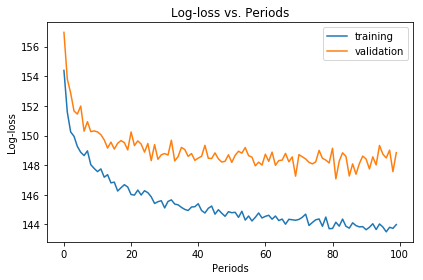

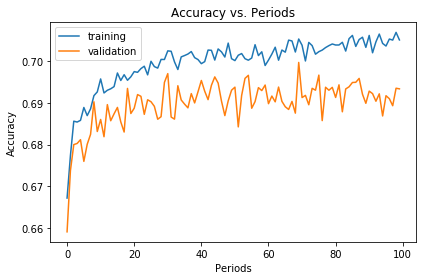

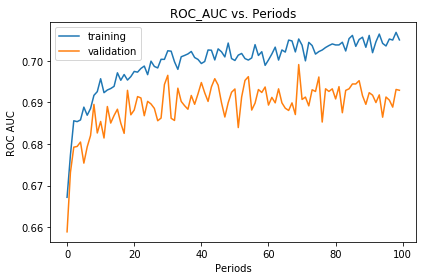

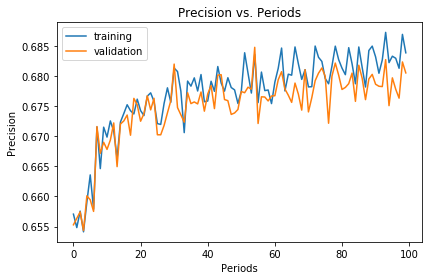

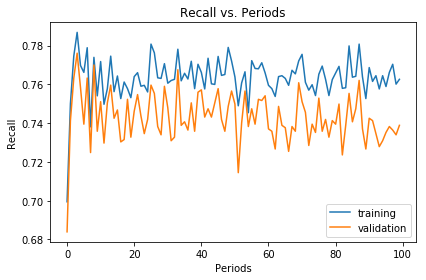

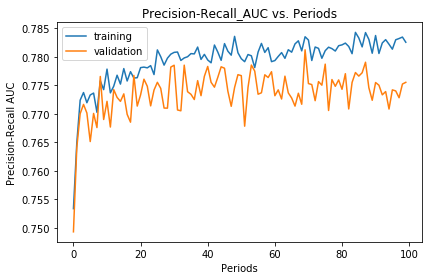

In [80]:
# Output a graph of log-loss metrics over periods.
plt.figure(1)
plt.ylabel("Log-loss")
plt.xlabel("Periods")
plt.title("Log-loss vs. Periods")
plt.tight_layout()
plt.plot(log_loss_train_f, label="training")
plt.plot(log_loss_test_f, label="validation")
plt.legend()

# Output a graph of accuracy over periods.
plt.figure(2)
plt.ylabel("Accuracy")
plt.xlabel("Periods")
plt.title("Accuracy vs. Periods")
plt.tight_layout()
plt.plot(accu_score_train_f, label="training")
plt.plot(accu_score_test_f, label="validation")
plt.legend()

# Output a graph of ROC AUC over periods.
plt.figure(3)
plt.ylabel("ROC AUC")
plt.xlabel("Periods")
plt.title("ROC_AUC vs. Periods")
plt.tight_layout()
plt.plot(roc_auc_train_f, label="training")
plt.plot(roc_auc_test_f, label="validation")
plt.legend()

# Output a precision score.
plt.figure(4)
plt.ylabel("Precision")
plt.xlabel("Periods")
plt.title("Precision vs. Periods")
plt.tight_layout()
plt.plot(precision_train_f, label="training")
plt.plot(precision_test_f, label="validation")
plt.legend()

# Output a recall score.
plt.figure(5)
plt.ylabel("Recall")
plt.xlabel("Periods")
plt.title("Recall vs. Periods")
plt.tight_layout()
plt.plot(recall_train_f, label="training")
plt.plot(recall_test_f, label="validation")
plt.legend()

# Output a graph of Precision-Recall AUC over periods.
plt.figure(6)
plt.ylabel("Precision-Recall AUC")
plt.xlabel("Periods")
plt.title("Precision-Recall_AUC vs. Periods")
plt.tight_layout()
plt.plot(pr_auc_train_f, label="training")
plt.plot(pr_auc_test_f, label="validation")
plt.legend()

Take a look on predictions share between 0 and 1

In [ ]:
print(np.bincount(training_predictions))
print(np.bincount(validation_predictions))